# Import Library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


# Load Dataset



download the dataset having the following associated classes:

  - 0 : airplane
  - 1 : automobile 
  - 2 : bird 
  - 3 : cat 
  - 4 : deer 
  - 5 : dog 
  - 6 : frog 
  - 7 : horse 
  - 8 : ship 
  - 9 : truck

  the training set turns out to have 50000 images

  the test set turns out to have 10000 images
  
  from the training set I will take 25% of images as validation, leaving only the remaining 75% to the training


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

num_classes = 10
CLASS= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("traing set is long: ", np.shape(x_train))
print("test set is long: ",  np.shape(x_test))

traing set is long:  (50000, 32, 32, 3)
test set is long:  (10000, 32, 32, 3)


Print the first 10 training images with the associated labels

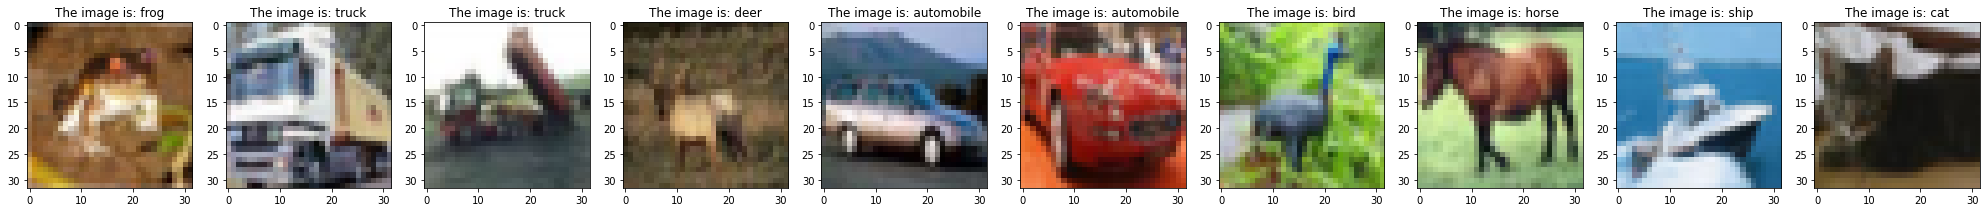

In [ ]:
f, axarr = plt.subplots(1,10,figsize=(35,10))

for i in range(0,10):
  index_label = y_train[i][0]
  axarr[i].imshow(x_train[i])
  axarr[i].title.set_text("The image is: " + CLASS[index_label])



## Preprocessing phase

First i convert pixel values to floats and normalize values in the range between 0 and 1


In [ ]:

x_train = np.array(x_train).astype(np.float32)
x_test = np.array(x_test).astype(np.float32)

# since the fixel value ranges from 0 to 255 I decided to normalize by dividing by the maximum value obtaining values between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0


convert each labels into categorical value 

In [ ]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

(y_train, y_test)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]], dtype=float32))

# Model Architecture 

Each image is of size 32 x 32 x 3 so I set the size of my network input to these values

In [ ]:
input_shape=(32,32,3)

The model consists of a first layer of Convolution which takes as input the size of an image 32 x 32 x 3 (rgb) and using 32 filters with kernel size 5,5 and Relu activation function.

Next, a MaxPooling layer can be found with a pool size of 2,2 followed by another convolutional layer but with twice as many filters (64) and last MaxPooling layer with the some pool_size of the previous.

In the Fully Connected layer part we find a Flatten layer followed by a Dropout of 0.5 units. Next we will have a Dense layer with 512 units and Dropout of 0.8, in this case the Dense layers have a relu activations.

In the last output layer we will have 10 units each corresponding to the various labels we had in the classes, consisting of softmax activation functions since it is a type of task concerning the classification of one of the 10 labels.

Various architectural configurations have been tried, such as decreasing the number of filters, increasing Convolutional lavers, increasing the number of units of Dense layers, etc., but among all of them, the current configuration is the best for me in terms of learning curve stability and complexity.


In [ ]:
#Craete the models architeture
model = Sequential()

# 1st Convolutional layer
model.add( Conv2D(32, (5,5), activation='relu', padding='same' ,  input_shape=(32,32,3)) )

# MaxPooling layer
model.add(MaxPooling2D(pool_size = (2,2)))

# 2st Convolutional layer
model.add( Conv2D(64, (5,5), activation='relu', padding='same'  ) )

# MaxPooling layer
model.add(MaxPooling2D(pool_size = (2,2)))

# Flatten Layer
model.add(Flatten())

# Drop out layer with 0.5 values
model.add(Dropout(0.5))

# Dense layer with 512 neurons
model.add(Dense(512 , activation='relu' ))

# Drop out layer with 0.8 values
model.add(Dropout(0.8))

# Final Dense layer with 10 neurons
model.add(Dense(10, activation='softmax'))

#Show a final model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4096)              0         
                                                                 
 dropout_6 (Dropout)         (None, 4096)             

## Training - Valuation Phase

The optimization function used was adam with loss of type categorical_crossentropy and early stopping to avoid making the learning go into overfitting in particular the control is done on the validation loss which if it does not increase after 3 epochs it will stop

The ideal batch size is on the 64-128 to have a good stability, while the average number of epochs among the various tests performed was 25-30 so as not to go into overfitting, the latter value can also be increased given earlystopping but I chose to leave it that way since I achieved an accuracy of around 73%.

As validation I used 25% of the size of the previously divided set

In [ ]:
# use categorical_crossentropy as loss and adam optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#EarlyStopping of validation_loss for avoid overfitting 
callback = EarlyStopping(monitor='val_loss', patience=3)

# take 75% for training data and other 25% for validation
history = model.fit(x_train, y_train,
          batch_size=64,
          epochs=50,
          callbacks=[callback],
          validation_split=0.25)


Epoch 1/50
586/586 [==============================] - 10s 16ms/step - loss: 1.7622 - accuracy: 0.3513 - val_loss: 1.4758 - val_accuracy: 0.4770
Epoch 2/50
586/586 [==============================] - 9s 15ms/step - loss: 1.4674 - accuracy: 0.4743 - val_loss: 1.2853 - val_accuracy: 0.5455
Epoch 3/50
586/586 [==============================] - 9s 15ms/step - loss: 1.3394 - accuracy: 0.5207 - val_loss: 1.3065 - val_accuracy: 0.5426
Epoch 4/50
586/586 [==============================] - 9s 15ms/step - loss: 1.2568 - accuracy: 0.5517 - val_loss: 1.0794 - val_accuracy: 0.6318
Epoch 5/50
586/586 [==============================] - 9s 15ms/step - loss: 1.1992 - accuracy: 0.5779 - val_loss: 1.0129 - val_accuracy: 0.6518
Epoch 6/50
586/586 [==============================] - 9s 15ms/step - loss: 1.1421 - accuracy: 0.5960 - val_loss: 0.9912 - val_accuracy: 0.6565
Epoch 7/50
586/586 [==============================] - 9s 15ms/step - loss: 1.1047 - accuracy: 0.6097 - val_loss: 0.9429 - val_accuracy: 0.675

### Test Accuracy

In [ ]:
loss, acc = model.evaluate(x_test, y_test)
print("Test set accuracy: {0:.4f}".format(acc))

313/313 [==============================] - 2s 5ms/step - loss: 0.7954 - accuracy: 0.7250
Test set accuracy: 0.7250


## Graph Visualizzation

### Model Accuracy

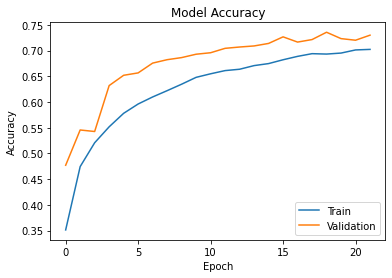

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='lower right')
plt.show()

### Model Loss

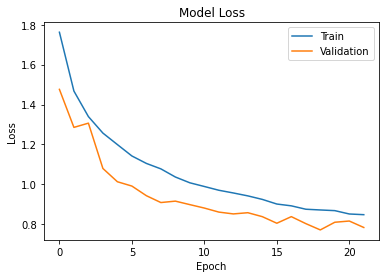

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

# Adversarial examples

## Fast Gradient Sign Method

adversarial_image = x + sign (∇x * J(θ, x, y)) * eps

- θ is the parameters of a model
- x the input to the model. --> my image
- y the targets associated with x  --> my label of image
- J(θ, x, y) be the cost used to train the model --> categorical_crossentropy

In [ ]:
def generate_image_adversary(model, image, label, eps=0.03):
    # cast the image
    image = tf.cast(image, tf.float32)
    
    # record our gradients
    with tf.GradientTape() as tape:
      # explicitly indicate that our image should be tacked for gradient updates
      tape.watch(image)
      # use our model to make predictions on the input image and then compute the loss
      pred = model(image)
      loss = categorical_crossentropy(label, pred)
      
    # calculate the gradients of loss with respect to the image, then
    # compute the sign of the gradient
    gradient = tape.gradient(loss, image)
    signedGrad = tf.sign(gradient)
    
    # construct the image adversary
    adversary = (image + (signedGrad * eps)).numpy()
    
    # return the image adversary to the calling function
    return adversary

### First example of application

I take the first test image and plot it

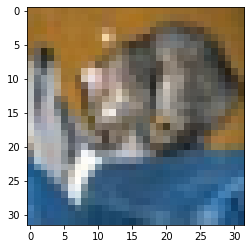

In [ ]:
image = x_test[0] 
label = y_test[0]

plt.imshow(image)

to find the adversarial image I use my function to calculate the new generated image with epslon value of 0.01

In [ ]:
#reshape my image to input model
image_reshaped = image.reshape(1, 32, 32, 3)
label_y = label.reshape(1,10)

adversary_image = generate_image_adversary(model,image_reshaped, label_y, eps=0.01)

now that I have obtained the opponent image I print it and calculate the labels returned by the model

In [ ]:
pred = model.predict(adversary_image)

pred_label = CLASS[np.argmax(pred)]

print("adversial image predicted label: " , pred_label)

adversial image predicted label:  dog


I turn it into the original size

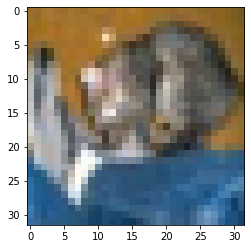

In [ ]:
image_adv = adversary_image.reshape(32,32,3) * 255

image_adv = np.clip(image_adv, 0, 255).astype("uint8")

plt.imshow(image_adv)

In [ ]:
img = x_test[0].reshape(1,32,32,3)

pred_label = CLASS[np.argmax(model.predict(img))]

print("original image predicted class: " , pred_label)

original image predicted class:  cat


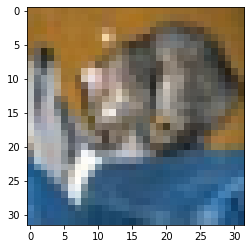

In [ ]:
original_image = img.reshape(32,32,3) * 255.0

original_image = np.clip(original_image, 0, 255.0).astype("uint8")

plt.imshow(original_image)

Compute difference between the two images to find the associated noise

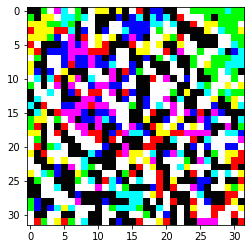

In [ ]:
noise = original_image - image_adv 
plt.imshow( noise)

save the three images to the disk

In [ ]:
cv2.imwrite('adversial.png', image_adv)
cv2.imwrite('original.png', original_image)
cv2.imwrite('noise.png', noise)

True

now use cv2 to make the difference more clear

True

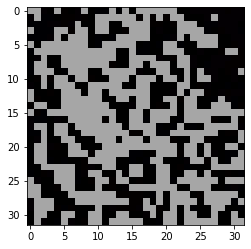

In [ ]:
# load images
image1 = cv2.imread("adversial.png")
image2 = cv2.imread("original.png")

# compute difference
difference = cv2.subtract(image2, image1)

# color the mask gray
Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)

# all values other than 0 indicate to me different pixels of the original image so I set them to 255 as a color
ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)

# colors all pixels that are not 255 of rgb grey = (166, 166, 166)
difference[mask != 255] = [166, 166, 166]

plt.imshow( difference)

# store images
cv2.imwrite('difference.png', difference)

## Let's try different epsilons

we can see how as epsilons increase noise increases, in particular a low epsilons value 0.01 already is enough to show how the image remains apparently unchanged but our model classifies it as a dog even though it represents a cat

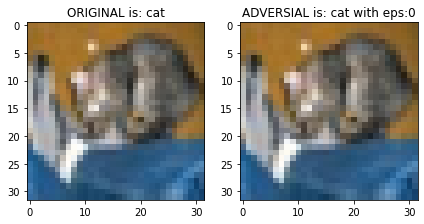

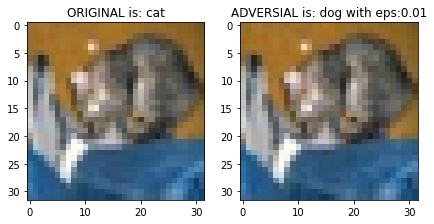

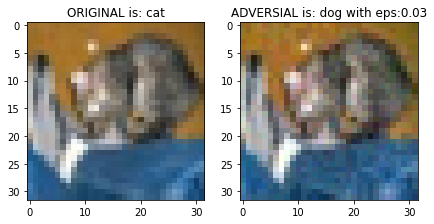

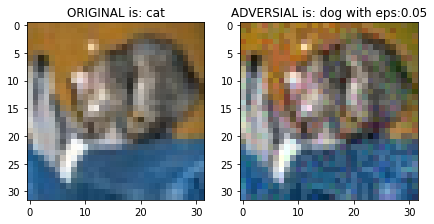

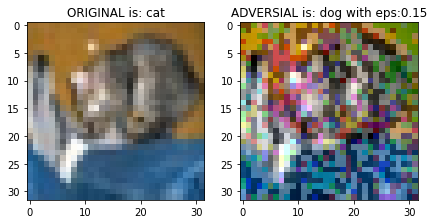

In [ ]:
epsilons = [0, 0.01, 0.03, 0.05, 0.15]
i = 0

for eps in epsilons:
  image = x_test[0] 
  label = y_test[0]

  img_original = image.reshape(1,32,32,3)
  label_y = label.reshape(1,10)

  adversary_image = generate_image_adversary(model,img_original, label_y, eps=eps)

  pred_label = CLASS[np.argmax(model.predict(adversary_image))]

  image_adv = np.clip(adversary_image.reshape(32,32,3) * 255.0, 0, 255.0).astype("uint8")

  pred_label_or = CLASS[np.argmax(model.predict(img_original))]

  f, axarr = plt.subplots(1,2,figsize=(7,5))

  axarr[0].imshow(x_test[i] )
  axarr[0].title.set_text("ORIGINAL is: " + pred_label_or)
  axarr[1].imshow(image_adv)
  axarr[1].title.set_text("ADVERSIAL is: " + pred_label + " with eps:" + str(eps) )



## Let's repeat the same procedure with the first 10 test images and see how it performs

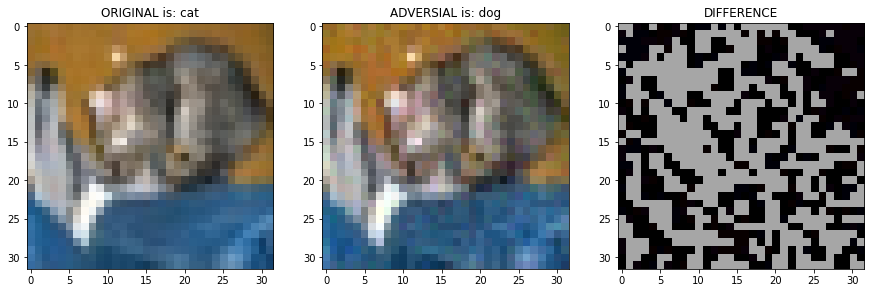

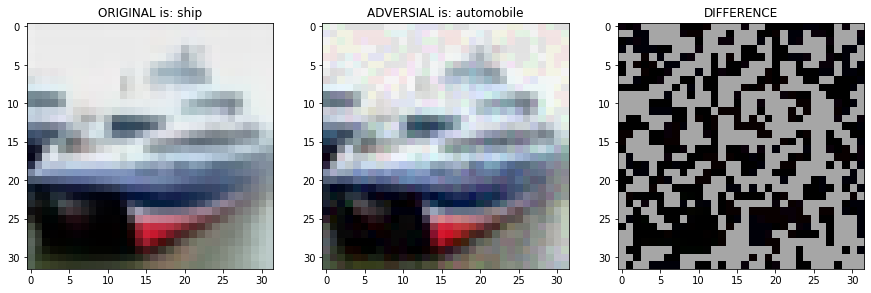

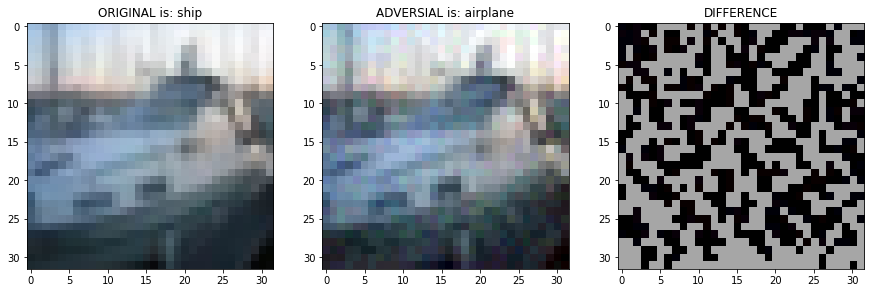

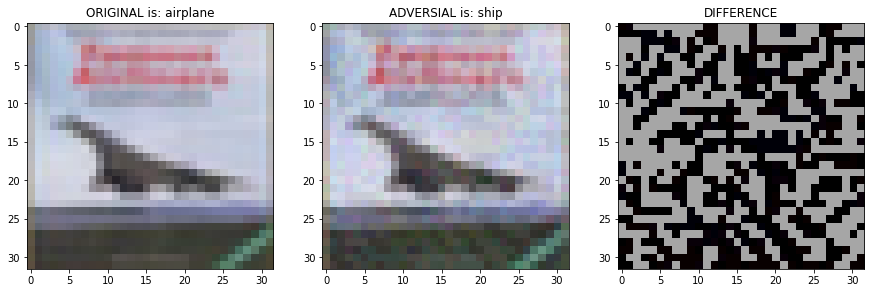

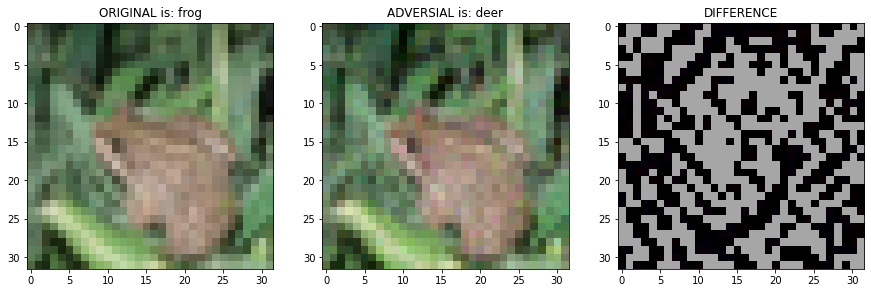

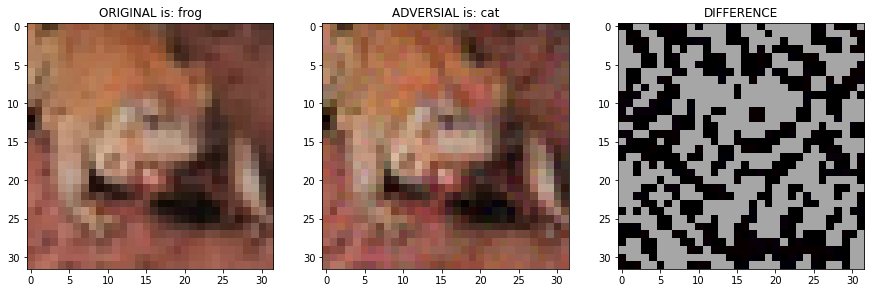

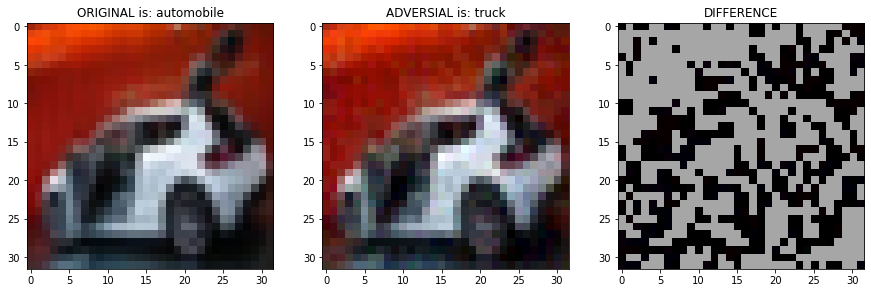

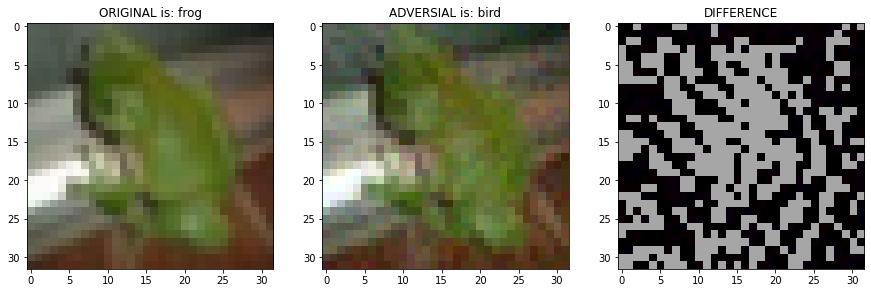

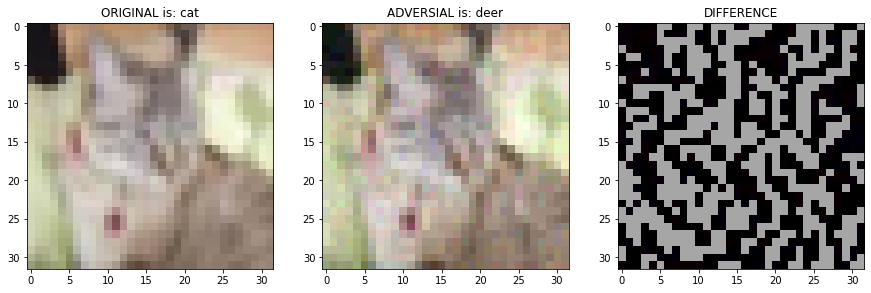

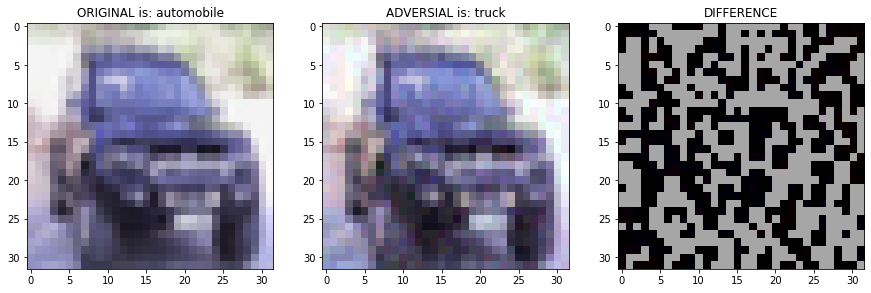

In [ ]:
image = x_test[0] 
label = y_test[0]

dim = 10

image_list = []

for i in range(0,dim):
  image = x_test[i] 
  label = y_test[i] 

  label_y = label.reshape(1,10)

  adversary_image = generate_image_adversary(model,image.reshape(1, 32, 32, 3), label_y)

  # find predicted label of adversary image
  pred_label = CLASS[np.argmax(model.predict(adversary_image))]
  
  img_or = image.reshape(1,32,32,3)
  pred_label_or = CLASS[np.argmax(model.predict(img_or))]

  #Turn it into the original size 
  image_adv = adversary_image.reshape(32,32,3) * 255.0
  image_adv = np.clip(image_adv, 0, 255.0).astype("uint8")

  cv2.imwrite('im2.png', image_adv)
  cv2.imwrite('im1.png', image.reshape(32,32,3) * 255)

  image1 = cv2.imread('im1.png')
  image2 = cv2.imread('im2.png')

  # compute difference
  difference = cv2.subtract(image1, image2)

  # color the mask 
  Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)

  # all values other than 0 indicate to me different pixels of the original image so I set them to 255 as the color
  # and then those all pixels that are not 255 of rgb grey = (166, 166, 166)
  ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255.0,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
  difference[mask != 255.0] = [166, 166, 166]
  
  f, axarr = plt.subplots(1,3,figsize=(15,10))

  axarr[0].imshow(image1)
  axarr[0].title.set_text("ORIGINAL is: " + pred_label_or)
  axarr[1].imshow(image2)
  axarr[1].title.set_text("ADVERSIAL is: " + pred_label)
  axarr[2].imshow(difference)
  axarr[2].title.set_text("DIFFERENCE")
  

# Consideration

The accuracy of my model is not the best (around 73%), certainly by increasing the complexity it was possible to go up a bit but the purpose was more to understand how one could build a convolutional model on this dataset and then test it. 

The Fast Gradient Sign method proved to be very useful in its application, in particular it was seen how changing different epson values made the image slightly noisy which led to the complete misclassification of my image. 

I think this was a very interesting Assignments and allowed me to understand in more detail the concepts seen previously in class in a more practical way.